## set up dependencies and util functions

In [278]:
import numpy as np
from dm_control import mujoco
import mediapy as media
import matplotlib.pyplot as plt

""

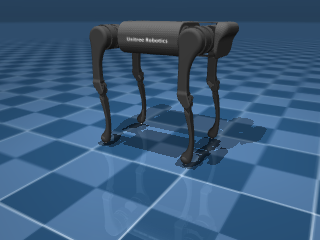

In [279]:
physics = mujoco.Physics.from_xml_path("../unitree_a1/scene.xml")
nv = physics.model.nv
nu = physics.model.nu
pixels = physics.render()
media.show_image(pixels)

In [280]:
import matplotlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def generate_video(physics, control, start_key=None, duration=1, framerate=30, camera_id=None):
    frames = []
    physics.reset(start_key)
    while physics.data.time < duration:
        physics.step()
        control(physics)
        if len(frames) < (physics.data.time) * framerate:
            if camera_id is None:
                pixels = physics.render()
            else:
                pixels = physics.render(camera_id=camera_id)
            frames.append(pixels)
    return media.show_video(frames, fps=framerate)


def generate_from_qpos(physics, qposes, fps, camera_id=None):
    frames = []
    for qpos in qposes:
        physics.data.qpos = qpos
        physics.data.qvel[:] = 0
        physics.forward()
        if camera_id is None:
            pixels = physics.render()
        else:
            pixels = physics.render(camera_id=camera_id)
        frames.append(pixels)
    return media.show_video(frames, fps=fps)    

def generate_pic_from_qpos(physics, qpos, camera_id=None):
    physics.data.qpos = qpos
    physics.data.qvel[:] = 0
    physics.forward()
    if camera_id is None:
        pixels = physics.render()
    else:
        pixels = physics.render(camera_id=camera_id)
    return media.show_image(pixels)

In [234]:
def simple_control(physics):
    e = (physics.model.key('home').qpos - physics.data.qpos)[7:]
    physics.data.ctrl =  e * 10

generate_video(physics, simple_control, duration=10, start_key=0)

In [235]:
conf0 = physics.model.qpos0
conf1 = conf0.copy()
conf1[0] += 1
u = np.linspace(0, 1, 100)
qpos_series = (1-u)[:, None] * conf0[None, :] + u[:, None] * conf1[None, :]

generate_from_qpos(physics, qpos_series, fps=30, camera_id=0)

In [6]:
joint_names = [physics.model.joint(i).name for i in range(physics.model.njnt) if physics.model.joint(i).name]
joint_ids = [physics.model.joint(name).dofadr[0] for name in joint_names]

contact_site_names = ["foot1", "foot2", "foot3", "foot4"]
contact_site_ids = [physics.model.site(name).id for name in contact_site_names]

In [7]:
physics.model.body('trunk').subtreemass
physics.model.body('trunk').inertia

mass = physics.model.body(1).subtreemass[0]
gravity = physics.model.opt.gravity

In [8]:
import casadi as ca
from copy import deepcopy

# this makes the dynamics super slow!
# lets change this in the future...

class _MyMassMatrix(ca.Callback):
    def __init__(self, physics):
        self.physics = deepcopy(physics)
        ca.Callback.__init__(self)
        self.construct("MyMassMatrix", {"enable_fd": True})

    def eval(self, q):
        self.physics.data.qpos = np.array(q).reshape(-1)
        self.physics.forward()
        
        nv = self.physics.model.nv
        M = np.zeros((nv, nv), dtype='float64')
        mujoco.mj_fullM(self.physics.model._model, M, self.physics.data.qM)
        return [M]
    
    def get_sparsity_out(self, i):
          if i==0:
                return ca.Sparsity.dense(self.physics.model.nv, self.physics.model.nv)

    def get_sparsity_in(self, i):
          if i==0:
                return ca.Sparsity.dense(self.physics.model.nq)


# casadi_M_func = ca.Function.load('../kino_dynamics_gen/casadi_functions/M.func')
casadi_M_func = _MyMassMatrix(physics)
# qhome = physics.model.key('home').qpos
# casadi_M_func(qhome)

## Utils

In [113]:
import numpy as np
import casadi as ca

def quadratic_cost(vec, mat):
    return vec.T @ mat @ vec

def rotation_matrix(axis, angle):
    # Normalize the axis
    axis = np.array(axis)
    axis /= np.linalg.norm(axis)

    # Construct the rotation matrix
    I = np.eye(3)
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    cross_mat = np.array([
        [0, -axis[2], axis[1]],
        [axis[2], 0, -axis[0]],
        [-axis[1], axis[0], 0]
    ])
    rotation_matrix = I + sin_angle * cross_mat + (1 - cos_angle) * cross_mat @ cross_mat

    # Convert to CasADi MX matrix
    rotation_matrix_mx = ca.MX(rotation_matrix)

    return rotation_matrix_mx

## First round optimization

In [344]:
# parameters. initialization

import casadi as ca

N_traj=20
physics.reset(0)
physics.forward()
com_to_feet = [
    physics.data.site(i).xpos - physics.data.body(1).subtree_com
    for i in contact_site_ids
]

init_M = casadi_M_func(physics.data.qpos)
init_I = init_M[3:6, 3:6]
inv_I = np.linalg.inv(init_I)
inv_I_z = init_I[2]

qpos_home = physics.data.qpos.copy()
qpos_dest = qpos_home.copy()
qpos_dest[0] += 3 # a simple destination. 3 units in x direction

X_ref = np.zeros((N_traj, 8))
X_ref[:, :3] = np.linspace(qpos_home[:3], qpos_dest[:3], N_traj)
X_ref[:, 4] = np.zeros(N_traj)
X_ref[1:, 4:] = X_ref[1:, :4] - X_ref[:-1, :4]

total_T = 3

dt = np.ones(N_traj-1) * total_T / (N_traj-1)

mu = 1 # or change?
mass = physics.model.body(1).subtreemass[0]
gravity = physics.model.opt.gravity

QX = np.diag([1, 1, 1, 1, 1, 1, 1, 1])
QH = np.diag([1, 1])
QF = np.diag([1, 1, 1])

In [345]:
def formulate_optimization(physics):
    opti = ca.Opti()
    
    X = [opti.variable(8) for i in range(N_traj)]
    q = [_X[:4] for _X in X]
    yaw = [_X[3] for _X in X]
    dq = [_X[4:] for _X in X]
    f_contact = [
        [opti.variable(3) for foot in contact_site_ids]
        for t in range(N_traj-1)
    ]
    
    # ignore q limits and qd limits for now as we don't have them in the model    
    # initial conditions
    opti.subject_to(X[0] == X_ref[0])
    opti.subject_to(X[-1] == X_ref[-1])
    
    cost = ca.MX(0)
    
    for t in range(N_traj-1):
        rot = rotation_matrix(np.array([0, 0, 1], dtype=float), yaw[t]) # rotate in z axis

        # dynamics constraint
        ddr = sum(f_contact[t][i] for i in range(len(contact_site_ids)))/mass + gravity
        dh = sum([ca.cross((rot @ r), fc) for r, fc in zip(com_to_feet, f_contact[t])])

        dyaw = inv_I_z * dh[2] # todo shouldn't we do matrix multiplication here?
        opti.subject_to(q[t+1] - q[t] == dt[t] * dq[t])  # euler integration. todo improve
        opti.subject_to(dq[t+1][:3] - dq[t][:3] == dt[t] * ddr)
        opti.subject_to(dq[t+1][3] - dq[t][3] == dt[t] * dyaw)
    
        # contact forces constraint
        for i in range(len(contact_site_ids)):
            opti.subject_to(f_contact[t][i][2] >= 0)
    
        # friction cone:
        for i in range(len(contact_site_ids)):
            x_force = f_contact[t][i][0]
            y_force = f_contact[t][i][1]
            z_force = f_contact[t][i][2]
            opti.subject_to(np.sqrt(2) * x_force <= mu * z_force) # why do we have to have sqrt(2)
            opti.subject_to(np.sqrt(2) * x_force >= -mu * z_force)
            opti.subject_to(np.sqrt(2) * y_force <= mu * z_force) # why do we have to have sqrt(2)
            opti.subject_to(np.sqrt(2) * y_force >= -mu * z_force)

        X_err = X[t] - X_ref[t]
        cost += sum([quadratic_cost(vec=X_err, mat=QX), 
                                quadratic_cost(vec=dh[:2], mat=QH),
                                *[quadratic_cost(vec=f_contact[t][i], mat=QF) for i, contact_id in enumerate(contact_site_ids)]])
    opti.minimize(cost)
    opti.solver('ipopt')
    opti.solve()
    return [opti.value(_X) for _X in X]

In [346]:
Xs = formulate_optimization(physics)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      795
Number of nonzeros in inequality constraint Jacobian.:      684
Number of nonzeros in Lagrangian Hessian.............:     2394

Total number of variables............................:      388
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      168
Total number of inequality constraints...............:      380
        inequality constraints with only lower bounds:       76
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      304

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4737701e+01 3.00e+00 5.79e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [347]:
qpos_series = []
for X in Xs:
    my_qpos = np.hstack([X[:3], np.cos(X[3]/2), 0, 0, np.sin(X[3]/2), qpos_home[7:]])
    qpos_series.append(my_qpos)
generate_from_qpos(physics, qpos_series, fps=10, camera_id=0)

In [348]:
generate_from_qpos(physics, qpos_series, fps=10, camera_id=2)